# การสร้าง Model สำหรับ Text Classification โดยใช้ Bag-of-word Feature กับ Standard Feedforward Neural Network

In [1]:
pip install thai_tokenizer

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
import csv
import numpy as np
import deepcut
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical, set_random_seed
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.metrics import confusion_matrix

set_random_seed(99)

**Read raw data form music_tu.csv.**

ขอให้ Copy File music_tu.csv ที่จะใช้ในตัวอย่างนี้จาก url ด้านล่างนี้ลงใน Google Drive ของตนเอง

https://drive.google.com/file/d/1B62Bl-mmZPrPmPWQDTczXJ_L6YPTwkK6/view?usp=sharing

และเปลี่ยนตำแหน่งของไฟล์ music_tu.csv ใน Source Code ด้านล่างนี้จาก '/content/drive/MyDrive/music_tu.csv' ไปเป็นตำแหน่งที่นักศึกษา Copy Folder ของภาพไว้ใน Google Drive ของตัวเอง

In [55]:
# Read input.txt and ans.txt into separate lists
with open('input.txt', 'r', encoding='utf-8-sig') as input_file:
    input_data = [line.strip().split('::')[1] for line in input_file]

with open('ans.txt', 'r', encoding='utf-8-sig') as ans_file:
    ans_data = [line.strip().split('::')[1] for line in ans_file]
    
# ans_data = [item[0] for item in ans_data]

# Create a list to store the combined data
combined_data = []

# Iterate through the input and ans data and combine them
for input_line, ans_line in zip(input_data, ans_data):
    combined_line = [ans_line, input_line]
    combined_data.append(combined_line)

# Shuffle the input data
shuffle(combined_data)
# Print the result as a list of lists
for combined_line in combined_data:
    print(combined_line)

['T,T,T', 'ในตานี้การ์ดในมือเน่า รอตาหน้าจะได้การ์ดดีๆ สรุปตาหน้าก็เน่าเหมือนเดิม']
['E', 'ตาเธอสวยเหมือนลูกแก้ว']
['E', 'ผู้คนมักไปทำตาสองชั้นที่ประเทศเกาหลี']
['P', 'ตากินยาหลังอาหารยัง']
['E', 'ซุปเปอร์แมนปล่อยเรเซอร์ออกมาจากตาเพื่อโกน']
['P,E', 'น้าจะพาคุณตาไปตรวจตาวันไหนหรอครับ']
['E,E', 'ภายนอกเขาอาจจะดูเหมือนคนปกติแต่เขาตาบอดตาใสน่ะ']
['E,E', 'ตาวิเศษจงบอกข้า ใครที่มีดวงตางามเริดสุดในดินแดนนี้']
['T,T', 'เอกสุ่มกาชาเกมส์ Genshin ไป 10 ตาพบว่าเกลือทุกตาเลย']
['E', 'ตาตี่แล้วมันผิดตรงไหน']
['T', 'ใครๆก็เล่นเกมเกิน1ตา']
['T', 'ตานี้ลงมอนไม่ได้เลย']
['T,T', 'ฉันเล่นตานี้ตาท้ายนะ']
['E,P', 'ด่าว่าฉันตาไม่ถึงเลยหรอ งั้นก็ไปร้องขอตานั่นละกันว่าขอส่งช้ากว่ากำหนด']
['T', 'เมื่อไหร่ตานี้จะจบสักที หิวข้าวแล้ว']
['P', 'อยู่ดีๆตาของฉันก็หายไป']
['E,E,P', 'ฉันอยากมีตาเหมือนกับนกเหยี่ยว เพราะสายตาของนกเหยี่ยวจะมองได้ไกล คุณตาของฉันเคยบอกไว้แบบนั้น']
['P', 'ตาเดินไปตลาด']
['P', 'ตาทำอาหาร']
['P', 'คุณตาที่อยู่อเมริกาโดยวัยรุ่นที่นั้นทำร้ายจนเสียชีวิต']
['E', 'ในสายตาของฉันนั้นมีแต่พี่ยองบิน']
[

**Create dataset. Extract labels and sentences.**

In [56]:
labels = [d[0] for d in combined_data]
sentences = [d[1] for d in combined_data]

print(labels)
print(sentences)

['T,T,T', 'E', 'E', 'P', 'E', 'P,E', 'E,E', 'E,E', 'T,T', 'E', 'T', 'T', 'T,T', 'E,P', 'T', 'P', 'E,E,P', 'P', 'P', 'P', 'E', 'T', 'E', 'E,T', 'P,E', 'P,E', 'E', 'P,P,P', 'P', 'P', 'P,E', 'P', 'E', 'P', 'T', 'P', 'T', 'P', 'P,P', 'E', 'P', 'T', 'T', 'E', 'P', 'T,T', 'E', 'E,E', 'T', 'P,T,E', 'E,E', 'P', 'T', 'E', 'P,P', 'T', 'P', 'P', 'E', 'P,E', 'P', 'P,E', 'P,E,E', 'E', 'P', 'P', 'E,P,E', 'P', 'P', 'E', 'E', 'E', 'T', 'P', 'P,E', 'T', 'E,E', 'E', 'P', 'E', 'T,E', 'E,P', 'E', 'P,T', 'E', 'P,P,E', 'P', 'P,P,E', 'E', 'T', 'E', 'E,P', 'P,E', 'T,P', 'E,P,P', 'P,P', 'E', 'P', 'P,E', 'P', 'E', 'E,E,E', 'T', 'T', 'P', 'E', 'T', 'E,E', 'P,E', 'E', 'P', 'E,P,T', 'E', 'E,E', 'P', 'T', 'P,E', 'P', 'P', 'E', 'E,T', 'E', 'P,E', 'T', 'E', 'T,T', 'P', 'P', 'P,P,T', 'E,E', 'E,E', 'E', 'E', 'E', 'T,T', 'T,T,T', 'P,T', 'E', 'P,P', 'E', 'E,E', 'E,P', 'E,E', 'P,E', 'P,T,P', 'E', 'E', 'E', 'P', 'E', 'T', 'P', 'E', 'P,P', 'E', 'P,P', 'P,P', 'E', 'E', 'E', 'P,T', 'P', 'P,E', 'E', 'P', 'T', 'E', 'P', 'E,P,T'

**Tokenize each sentence into a list of words.**

In [57]:
# words = [[w for w in deepcut.tokenize(s) if w != ' '] for s in sentences]
# for sentence in words:
#     print(sentence)
from pythainlp.tokenize import word_tokenize
from thai_tokenizer import Tokenizer
tokenizer = Tokenizer()
# Tokenize the sentences using the ThaiTokenizer
# words = [[w for w in tokenizer.split(s) if w != ' '] for s in sentences]
 #Pythai Tokenize
words = [[w for w in word_tokenize(s, engine="newmm", keep_whitespace=False)] for s in sentences]

# Print the tokenized words
for sentence in words:
    print(sentence)

['ใน', 'ตา', 'นี้', 'การ์ด', 'ใน', 'มือ', 'เน่า', 'รอ', 'ตา', 'หน้า', 'จะ', 'ได้', 'การ์ด', 'ดี', 'ๆ', 'สรุป', 'ตา', 'หน้า', 'ก็', 'เน่า', 'เหมือนเดิม']
['ตา', 'เธอ', 'สวย', 'เหมือน', 'ลูกแก้ว']
['ผู้คน', 'มัก', 'ไป', 'ทำตา', 'สองชั้น', 'ที่', 'ประเทศ', 'เกาหลี']
['ตา', 'กิน', 'ยา', 'หลังอาหาร', 'ยัง']
['ซุปเปอร์', 'แมน', 'ปล่อย', 'เร', 'เซอร์', 'ออก', 'มาจาก', 'ตา', 'เพื่อ', 'โกน']
['น้า', 'จะ', 'พา', 'คุณตา', 'ไป', 'ตรวจ', 'ตา', 'วัน', 'ไหน', 'หรอ', 'ครับ']
['ภายนอก', 'เขา', 'อาจจะ', 'ดูเหมือน', 'คน', 'ปกติ', 'แต่', 'เขา', 'ตาบอดตาใส', 'น่ะ']
['ตา', 'วิเศษ', 'จง', 'บอก', 'ข้า', 'ใคร', 'ที่', 'มี', 'ดวงตา', 'งาม', 'เริด', 'สุด', 'ใน', 'ดินแดน', 'นี้']
['เอก', 'สุ่ม', 'กา', 'ชา', 'เกมส์', 'Genshin', 'ไป', '10', 'ตา', 'พบ', 'ว่า', 'เกลือ', 'ทุก', 'ตา', 'เลย']
['ตาตี่', 'แล้ว', 'มัน', 'ผิด', 'ตรงไหน']
['ใครๆ', 'ก็', 'เล่น', 'เกม', 'เกิน', '1', 'ตา']
['ตา', 'นี้', 'ลง', 'มอน', 'ไม่', 'ได้', 'เลย']
['ฉัน', 'เล่นตา', 'นี้', 'ตา', 'ท้าย', 'นะ']
['ด่าว่า', 'ฉัน', 'ตา', 'ไม่', 'ถึง', 'เลย', 'ห

In [67]:
from keras.utils import to_categorical

# Initialize empty lists for y1, y2, and y3
y1, y2, y3 = [], [], []

# Loop through your labels and split them into three parts
for i in labels:
    if len(i) == 3:
        y1.append(combined_data[i[0]] if i[0] in combined_data else 4)  # 4 represents 'E'
        y2.append(combined_data[i[1]] if i[1] in combined_data else 4)
        y3.append(combined_data[i[2]] if i[2] in combined_data else 4)
    elif len(i) == 2:
        y1.append(combined_data[i[0]] if i[0] in combined_data else 4)
        y2.append(combined_data[i[1]] if i[1] in combined_data else 4)
        y3.append(4)  # 'E' is assumed to be a default value for y3
    elif len(i) == 1:
        y1.append(combined_data[i[0]] if i[0] in combined_data else 4)
        y2.append(4)  # 'E' is assumed to be a default value for y2
        y3.append(4)  # 'E' is assumed to be a default value for y3

# Convert y1, y2, and y3 to one-hot encoded categorical format
y1 = to_categorical(y1, num_classes=5)  # Adjust num_classes according to your mapping
y2 = to_categorical(y2, num_classes=5)  # Adjust num_classes according to your mapping
y3 = to_categorical(y3, num_classes=5)  # Adjust num_classes according to your mapping

# Create the final list of y_train_last
y_train_last = [y1, y2, y3]

# Check the shapes of the resulting arrays
print(y_train_last[0].shape, y_train_last[1].shape, y_train_last[2].shape)

for i in y_train_last[0]:
    print(i)

(4405, 5) (4405, 5) (4405, 5)
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[

**Find all possible words (vocab).**

In [68]:
vocab = set([w for s in words for w in s])
print('Vocab size = '+str(len(vocab)))
print(vocab)


Vocab size = 4608
{'รูป', 'การงาน', 'จิก', 'Void', 'ยิงปืน', 'หน้าม้า', 'เลี่ยง', 'ว่ะ', 'สเต็ก', 'ฟู', 'แดด', 'สะพานลอย', 'นัน', 'ฟอ', 'สักที', 'คะ', 'สุดใจ', 'ใต้', 'บาสเกตบอล', 'พ่น', 'ใบตอง', 'หนุ่ม', 'รื้อ', 'บทความ', 'เจอกัน', 'ทันทีที่', 'เศร้า', 'พาร์ท', 'ตื่นนอน', '14', 'จำ', 'ทางกรรมพันธุ์', 'เหี้ยน', 'เหมือนว่า', 'จนได้', 'สักพัก', 'ผิดหวัง', 'ฟันปลอม', 'สมุย', 'มัก', 'ฉััน', 'DIY', 'วน', 'ตัด', 'ธร', 'หนังสือพิมพ์', 'คำปรึกษา', 'ใดๆ', 'ลง', 'ซัด', 'เละ', 'แครอท', 'รู้จัก', 'เชื่อฟัง', 'แข็งแกร่ง', 'ทุบ', 'ม่าน', 'สนามกอล์ฟ', 'มืด', 'ที่แล้ว', 'เติบ', 'ตาดำ', 'ประคบ', 'สิ้นคิด', 'การบ้าน', 'ชาญ', 'barbatos', 'ร่มไม้', 'ผีปอบ', 'อุลตร้าแมน', 'แกก็ห้าม', 'มมาก', 'เเบบ', 'เป็นไป', 'คำบรรยาย', 'รสชาติ', 'ไกล', 'แส', 'ดาระ', 'บ้านพักตากอากาศ', 'ทางกฎหมาย', 'ควาย', 'เทคโนโลยี', 'ใคร', 'ตื่นขึ้น', 'สมรัก', 'ไม่ลืมหูลืมตา', 'ไหว้', 'อต', 'หวัง', '20', 'ฝึก', 'เหยียดหยาม', 'มุทิตา', 'เดินเล่น', 'คุง', 'สภาพ', 'เจี้ยบ', 'เหยี่ยน', 'กินตา', 'ข้างนอก', 'ทำแทน', 'หวาน', 'รวดเร็ว', 'สามี'

**Extract bag-of-word feature for each sentence**

In [ ]:
bag_of_words = np.zeros((len(words),len(vocab)))
for i in range(0,len(words)): # i = sentence id
    count = 0
    for j in range(0,len(words[i])): # j = word id
        k = 0
        for w in vocab:
            if(words[i][j] == w):
                bag_of_words[i][k] = bag_of_words[i][k]+1
                count = count+1
            k = k+1
    bag_of_words[i] = bag_of_words[i]/count

print(bag_of_words.shape)
print(bag_of_words[0])

(4818, 4608)
[0. 0. 0. ... 0. 0. 0.]


**Create a feedforward neural network.**

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Assuming you have defined your vocabulary size and num_classes
vocab_size = len(vocab)
num_classes = 3

input_layer = Input(shape=(vocab_size,))
h1 = Dense(64, activation="tanh")(input_layer)
dropout_layer = Dropout(0.5)(h1)
h2 = Dense(64, activation="tanh")(dropout_layer)
dropout_layer = Dropout(0.5)(h2)
h3 = Dense(64, activation="tanh")(dropout_layer)
dropout_layer = Dropout(0.5)(h3)
h4 = Dense(64, activation="tanh")(dropout_layer)
dropout_layer = Dropout(0.5)(h4)
h5 = Dense(64, activation="tanh")(dropout_layer)
dropout_layer = Dropout(0.5)(h5)
h6 = Dense(64, activation="tanh")(dropout_layer)

output_layer = Dense(num_classes, activation="softmax")(h6)

model = Model(inputs=input_layer, outputs=output_layer)

# Define learning rate and optimizer
custom_learning_rate = 0.001
custom_optimizer = Adam(learning_rate=custom_learning_rate)

# Compile the model
model.compile(optimizer=custom_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4608)]            0         
                                                                 
 dense_21 (Dense)            (None, 64)                294976    
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0   

**Train the network with training set + validation set of 240 samples (0-239).**

In [ ]:
unique_labels = np.unique(labels)
num_classes = len(unique_labels)
print(f"Number of unique classes: {num_classes}")
print(f"Unique classes: {unique_labels}")
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

# Define a ModelCheckpoint callback to save the best model weights
model_checkpoint = ModelCheckpoint(
    "model_9.h5",
    monitor="val_accuracy",  # Monitor validation accuracy
    save_best_only=True,  # Save only the best models
    mode="max",  # Save when validation accuracy is maximized
    verbose=1,
)

# Train 80% of the data
# Test 20% of the data
# Validation 50% of the data
history = model.fit(
    bag_of_words[:3855],
    one_hot_labels[:3855],
    epochs=300,
    batch_size=50,
    validation_split=0.2,
    callbacks=[model_checkpoint],
)

Number of unique classes: 3
Unique classes: ['E' 'P' 'T']
Epoch 1/300
59/62 [===========================>..] - ETA: 0s - loss: 1.0324 - accuracy: 0.4149
Epoch 1: val_accuracy improved from -inf to 0.38392, saving model to model_9.h5
62/62 [==============================] - 4s 19ms/step - loss: 1.0285 - accuracy: 0.4196 - val_loss: 0.9968 - val_accuracy: 0.3839
Epoch 2/300
61/62 [============================>.] - ETA: 0s - loss: 0.7919 - accuracy: 0.6184
Epoch 2: val_accuracy improved from 0.38392 to 0.78470, saving model to model_9.h5
62/62 [==============================] - 1s 13ms/step - loss: 0.7920 - accuracy: 0.6193 - val_loss: 0.5612 - val_accuracy: 0.7847
Epoch 3/300
62/62 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.7892
Epoch 3: val_accuracy improved from 0.78470 to 0.80285, saving model to model_9.h5
62/62 [==============================] - 1s 14ms/step - loss: 0.5336 - accuracy: 0.7892 - val_loss: 0.5181 - val_accuracy: 0.8029
Epoch 4/300
61/62 [==

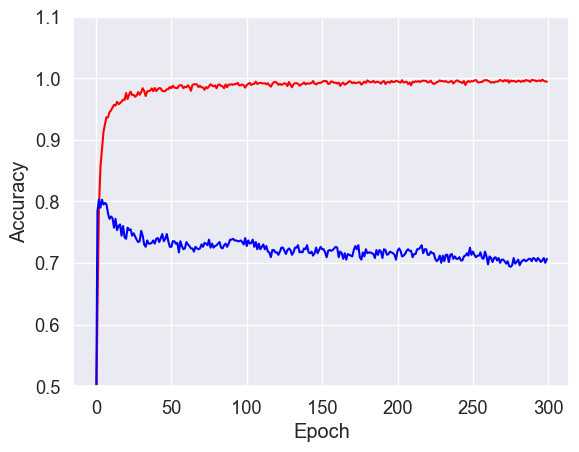

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy', color='red')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.show()

**Test the network with test set of 60 samples (240-299).**

31/31 [==============================] - 0s 3ms/step


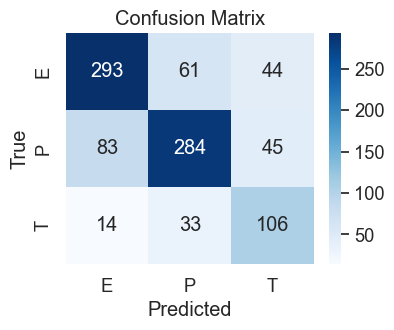

Accuracy
0.7092419522326064
Classification Report
              precision    recall  f1-score   support

           E       0.75      0.74      0.74       398
           P       0.75      0.69      0.72       412
           T       0.54      0.69      0.61       153

    accuracy                           0.71       963
   macro avg       0.68      0.71      0.69       963
weighted avg       0.72      0.71      0.71       963



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Assuming you have a test dataset called 'test_bag_of_words' and 'test_labels'
test_bag_of_words = bag_of_words[3855:]
test_labels = labels[3855:]

# Calculate predicted probabilities
y_pred_probs = model.predict(test_bag_of_words)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Encode true labels using the same LabelEncoder
label_encoder = LabelEncoder()
encoded_true_labels = label_encoder.fit_transform(test_labels)

# Calculate confusion matrix
cm = confusion_matrix(encoded_true_labels, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(encoded_true_labels, y_pred_labels)
print('Accuracy')
print(accuracy)

# Generate classification report with specified labels
report = classification_report(
    encoded_true_labels,
    y_pred_labels,
    target_names=label_encoder.classes_,
    labels=np.unique(encoded_true_labels)  # Use unique labels to ensure correct order
)
print('Classification Report')
print(report)

In [ ]:
from keras.models import load_model
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Load the best model
best_model = load_model('model_9.h5')

# Assuming you have a test dataset called 'test_bag_of_words' and 'test_labels'
# Perform the same preprocessing for test data as you did for training data
test_encoded_labels = label_encoder.transform(test_labels)
test_one_hot_labels = to_categorical(test_encoded_labels)

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(test_bag_of_words, test_one_hot_labels)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


31/31 [==============================] - 0s 3ms/step - loss: 0.5464 - accuracy: 0.7902
Test Accuracy: 79.02%
Test Loss: 0.5464
